<a href="https://colab.research.google.com/github/PaleoLipidRR/marine-AOA-GDGT-distribution/blob/main/PNAS_pythonCodeS1_BeyondTEX86_preprocessing_RR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Python Code S1**

## Supplementary Information for:
## Beyond TEX86: GDGT inform marine archaea ecology and evolution
Ronnakrit Rattanasriampaipong, Yi Ge Zhang, Ann Pearson, Brian Hedlund, and Shuang Zhang

Corresponding Author: Ronnakrit Rattanasriampaipong
E-mail: rrattan@tamu.edu
***

Notebook Description:

This is a jupyter containing python scripts that we use to pre-process GDGT database and generate the processed GDGT datasets (output as Dataset S1) to be used for data analysis. The input file (Dataset S1) is a composite GDGT database used for this study from the Python Code S1 (see SI Appendix).

***


In [1]:
import warnings
warnings.filterwarnings("ignore") 
warnings.warn('ProplotWarning:')

# **1. Import python packages of interest**

### 1.1 Mounting your google drive with Google colab so that you can read files directly from the google drive

In [2]:
# # Mounting your google drive
# from google.colab import drive

# ROOT = "/content/drive"
# drive.mount(ROOT,force_remount=True)


### 1.2 Computation and Data Analytics

In [3]:
import pandas as pd
import numpy as np
import xarray as xr
import seaborn as sns

import scipy as scipy
from scipy import stats
from sklearn import linear_model, datasets
from sklearn import mixture
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor

### 1.2 Data plotting and visualizations

**Uncomment !apt-get if you run this notebook from Colab.**
shapely and cartopy are not good friends, especially on Google Colab

In [4]:
# ### %%capture is a command to suppress cell's outputs. So, please do not worry if you don't see anything coming out after running the cell. I just don't want to let the installations overwhelming your screen.
# %%capture
# !apt-get install libproj-dev proj-data proj-bin
# !apt-get install libgeos-dev
# %pip install cartopy
# !apt-get -qq install python-cartopy python3-cartopy
# %pip uninstall -y shapely    # cartopy and shapely aren't friends (early 2020)
# %pip install shapely --no-binary shapely
# %pip install proplot 
# %pip install pyrolite  ### This is to install libraries that are not available in Google Colab

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib.patches import Rectangle

import proplot as plot
import cartopy.crs as ccrs

from pyrolite.util.time import Timescale
gts = Timescale()


###  1.3 Miscellaneous

In [6]:
import string
import os
import requests
import io
import netCDF4
from netCDF4 import Dataset

import dask

### 1.4 pyGplates for paleolocation reconstruction

In [7]:
import pygplates

###  1.5 Useful functions

In [8]:
def sigmaT_cal_Miller_and_Poisson_1981(temp_array,sal_array):
    '''
    This is a function for seawater density (sigma-t) calculation based on seawater temperature and salinity.
    The calculations follow Miller and Poisson (1981).
    
    Reference:
    Millero, F. J., & Poisson, A. (1981). International one-atmosphere equation of state of seawater. Deep Sea Research Part A. Oceanographic Research Papers, 28(6), 625-629.
    '''
    #Miller and Poisson (1981)
    #parameter for sigma calculation
    A = 8.24493e-1 - 4.0899e-3*temp_array + 7.6438e-5*(temp_array**2) - 8.2467e-7*(temp_array**3) + 5.3875e-9*(temp_array**4)
    B = -5.72466e-3 + 1.0227e-4*temp_array - 1.6546e-6*(temp_array**2)
    C = 4.8314e-4
    rho_0=999.842594 + 6.793952e-2*temp_array - 9.095290e-3*(temp_array**2) + 1.001685e-4*(temp_array**3) - 1.120083e-6*(temp_array**4) + 6.536336e-9*(temp_array**5)
    rho=rho_0 + (A*sal_array) + (B*(sal_array**1.5)) + (C*(sal_array**2))
    return rho-1000

def rollmean_calculation_step(sel_df,sel_attribute,younger_age,older_age,bin_step):
    '''
    sel_attribute is the column name e.g., 'paleoDepth_adjusted'
    
    Return the array with 5 columns:
    array_rollmean[:,0:4]
    0: plot_timestep
    1: mean
    2: median
    3: lower iqr (percentile 25th)
    4: upper iqr (percentile 75th)
    5: minimum of data range (percentile 0)
    6: maximum of data range (percentile 100)
    '''
    
    attributes = [sel_attribute]
    
    plot_timestep = np.arange(younger_age,older_age+bin_step,bin_step)
    nbins = len(plot_timestep)
    array_rollmean = np.empty((nbins,7))
    array_rollmean[:,0] = plot_timestep

    min_counts = 3


    sel_group = sel_df[sel_df.dataType_level0=="Ancient"]

    for i in range(len(array_rollmean[:,0])):
        if sel_group[sel_attribute].where((sel_group.sampleAge>=plot_timestep[i])&
                                          (sel_group.sampleAge<plot_timestep[i]+bin_step)).count() <=min_counts:
            array_rollmean[i,1] = np.nan
            array_rollmean[i,2] = np.nan
            array_rollmean[i,3] = np.nan
            array_rollmean[i,4] = np.nan
            array_rollmean[i,5] = np.nan
            array_rollmean[i,6] = np.nan


        else:
            bin_data = sel_group[sel_attribute].where((sel_group.sampleAge>=plot_timestep[i])&
                                                      (sel_group.sampleAge<plot_timestep[i]+bin_step))
            array_rollmean[i,1] = bin_data[~np.isnan(bin_data)].mean()
            
            a = scipy.stats.mstats.mquantiles(bin_data[~np.isnan(bin_data)], prob=[0,0.25, 0.5, 0.75,1], alphap=0.4, betap=0.4,axis=None, limit=())
            array_rollmean[i,2] = a[2]
            array_rollmean[i,3] = a[1]
            array_rollmean[i,4] = a[3]
            
            array_rollmean[i,5] = a[0]
            array_rollmean[i,6] = a[4]


            
    return array_rollmean


#### codes to generate woa urls modified from https://pyoceans.github.io/python-oceans/_modules/oceans/datasets.html
def _woa_variable(variable):
    _VAR = {
        'temperature': 't',
        'salinity': 's',
        'silicate': 'i',
        'phosphate': 'p',
        'nitrate': 'n',
        'oxygen_saturation': 'O',
        'dissolved_oxygen': 'o',
        'apparent_oxygen_utilization': 'A',
    }
    v = _VAR.get(variable)
    if not v:
        raise ValueError(
            f'Unrecognizable variable. Expected one of {list(_VAR.keys())}, got "{variable}".'
        )
    return v

def _woa_url(variable, time_period, resolution):
    base = 'https://www.ncei.noaa.gov/thredds-ocean/dodsC'

    v = _woa_variable(variable)

    if variable not in ['salinity', 'temperature']:
        pref = 'woa09'
        warnings.warn(
            f'The variable "{variable}" is only available at 1 degree resolution, '
            f'annual time period, and "{pref}".'
        )
        return (
            f'{base}/'
            f'{pref}/'
            f'{variable}_annual_1deg.nc'
        )
    else:
        dddd = 'decav'
        pref = 'woa18'

    grids = {
        '5': ('5deg', '5d'),
        '1': ('1.00', '01'),
        '04': ('0.25', '04'),
    }
    grid = grids.get(resolution)
    if not grid:
        raise ValueError(
            f'Unrecognizable resolution. Expected one of {list(grids.keys())}, got "{resolution}".'
        )
    res = grid[0]
    gg = grid[1]

    time_periods = {
        'annual': '00',
        'january': '01',
        'february': '02',
        'march': '03',
        'april': '04',
        'may': '05',
        'june': '06',
        'july': '07',
        'august': '08',
        'september': '09',
        'october': '10',
        'november': '11',
        'december': '12',
        'winter': '13',
        'spring': '14',
        'summer': '15',
        'autumn': '16',
    }

    time_period = time_period.lower()
    if len(time_period) == 3:
        tt = [time_periods.get(k) for k in time_periods.keys() if k.startswith(time_period)][0]
    elif len(time_period) == 2 and time_period in time_periods.values():
        tt = time_period
    else:
        tt = time_periods.get(time_period)

    if not tt:
        raise ValueError(
            f'Unrecognizable time_period. '
            f'Expected one of {list(time_periods.keys())}, got "{time_period}".'
        )

    url = (
        f'{base}'
        '/ncei/woa/'
        f'{variable}/decav/{res}/'
        f'{pref}_{dddd}_{v}{tt}_{gg}.nc'  # '[PREF]_[DDDD]_[V][TT][FF][GG]' Is [FF] used?
    )
    return url

   #  variables:
   #      'temperature': 't',
   #      'salinity': 's',
   #      'silicate': 'i',
   #      'phosphate': 'p',
   #      'nitrate': 'n',
   #      'oxygen_saturation': 'O',
   #      'dissolved_oxygen': 'o',
   #      'apparent_oxygen_utilization': 'A',
   # time_periods:
   #      'annual': '00',
   #      'january': '01',
   #      'february': '02',
   #      'march': '03',
   #      'april': '04',
   #      'may': '05',
   #      'june': '06',
   #      'july': '07',
   #      'august': '08',
   #      'september': '09',
   #      'october': '10',
   #      'november': '11',
   #      'december': '12',
   #      'winter': '13',
   #      'spring': '14',
   #      'summer': '15',
   #      'autumn': '16',
   # resolutions:
   #  '5': ('5deg', '5d'),
   #  '1': ('1.00', '01'),
   #  '04': ('0.25', '04'),
        

    # an=Objectively analyzed climatologies are the objectively interpolated mean fields for oceanographic variables at standard depth levels for the World Ocean.
    # mn=The statistical mean is the average of all unflagged interpolated values at each standard depth level for each variable in each 1° square which contains at least one

# **2. Load and clean datasets**

In [11]:
pd.set_option('display.max_rows',4,'display.max_columns',10)
# filepath = "/content/drive/MyDrive/Colab Notebooks/Excel/MarineAOA_project/"  ### Replace with your the location of your file
filepath = "C:/Users/ratta/working-repo/spreadsheets/"
filename = "PNAS_datasetS1_BeyondTEX86_RR.xlsx"

df = pd.read_excel(filepath+filename)
df = df.rename(columns={
                        'Sample Age (Ma)':'sampleAge',
                        'Broad Filtration Class':'lipidClass',
                        'Lipid Extractions':'lipidExtractionMethod',
                        'Filter pore size':'filterPoreSize',
                        'Geological Age\n(Name)':'geoEpoch'
                       })
df.columns

Index(['sampleName', 'drilling_program', 'Site', 'Site_edited', 'Latitude',
       'Longitude', 'Collection_date', 'Collection_year', 'Collection_month',
       'Seasonal_month', 'sampleID_new', 'modernWaterDepth', 'sampleDepth',
       'sampleAge', 'reported_Temp', 'reported_T_method', 'reported_Salinity',
       'reported_S_method', 'reported_pH', 'reported_pH_method', 'lipidClass',
       'lipidExtractionMethod', 'filterPoreSize', 'reported_1302',
       'reported_1300', 'reported_1928', 'reported_1296', 'reported_1294',
       'reported_1292', 'reported_1292_iso', 'reported_1050',
       'reported_1050_isomer1', 'reported_1048', 'reported_1048_isomer1',
       'reported_1046', 'reported_1046_isomer1', 'reported_1036',
       'reported_1036_isomer1', 'reported_1034', 'reported_1034_isomer1',
       'reported_1032', 'reported_1032_isomer1', 'reported_1022',
       'reported_1020', 'reported_1018', 'cal_frac_1302', 'cal_frac_1300',
       'cal_frac_1298', 'cal_frac_1296', 'cal_frac_12

In [32]:
pd.set_option("min_rows", 20)
df[df.dataType_level0=='Modern']['dataType_level1'].unique()

array(['Water-column SPM', 'Hot spring', 'Core top'], dtype=object)

## 2.1 First, we remove data points that may be below detection limit (BDL)
Data points with very low reported raw/fractional abundances (<=0.001) of isoGDGTs will be removed.

In [12]:
def BDL_histogram():
    plot.rc.update({'text.labelsize':8})
    plot.rc.update({'font.size':8})
    fig, axs = plot.subplots(ncols=2,nrows=6,figsize=(6,6),wratios=(3,1),wspace='1em',hspace='1em')
    axs.format(
      suptitle="Histograms show distributions of each GDGT fraction",
      xlabel=""
    )
    features = ['cal_frac_1302','cal_frac_1300','cal_frac_1298','cal_frac_1296','cal_frac_1292','cal_frac_1292_iso']
    title_labels = ['GDGT-0','GDGT-1','GDGT-2','GDGT-3','Cren',"Cren'"]
    ii = 0
    jj = 1
    for i in range(6):
        ax = axs[ii]
        data = df[features[i]]
        n, bins, patches = ax.hist(data,bins=np.arange(0,1,0.001),edgecolor=None,color='0.5')
        patches[0].set_fc('r')
        ii += 2
        ax.format(
            urtitle=title_labels[i]
        )
        
        ax = axs[jj]
        n, bins, patches = ax.hist(data,bins=np.arange(0,1,0.001),edgecolor=None,color='0.5')
        patches[0].set_fc('r')
        ax.format(
            xlim=(-0.02,0.05)
        )
        jj += 2
        ax.format(
            urtitle=title_labels[i]
        )
    axs.format(
        ylabel="Number of observations (n) in each bin",
        xlabel="Relative abundances (from 0 to 1; bin size = 0.001)"
    )
    filepath = "C:/Users/ratta/marine-AOA-GDGT-distribution/figures/supplementary-figure/"
    filename = "figS8_SI_PNAS_belowDetectionLimit.pdf"
    fig.savefig(filepath+filename,dpi=330,bbox_inches='tight')
    plt.show()

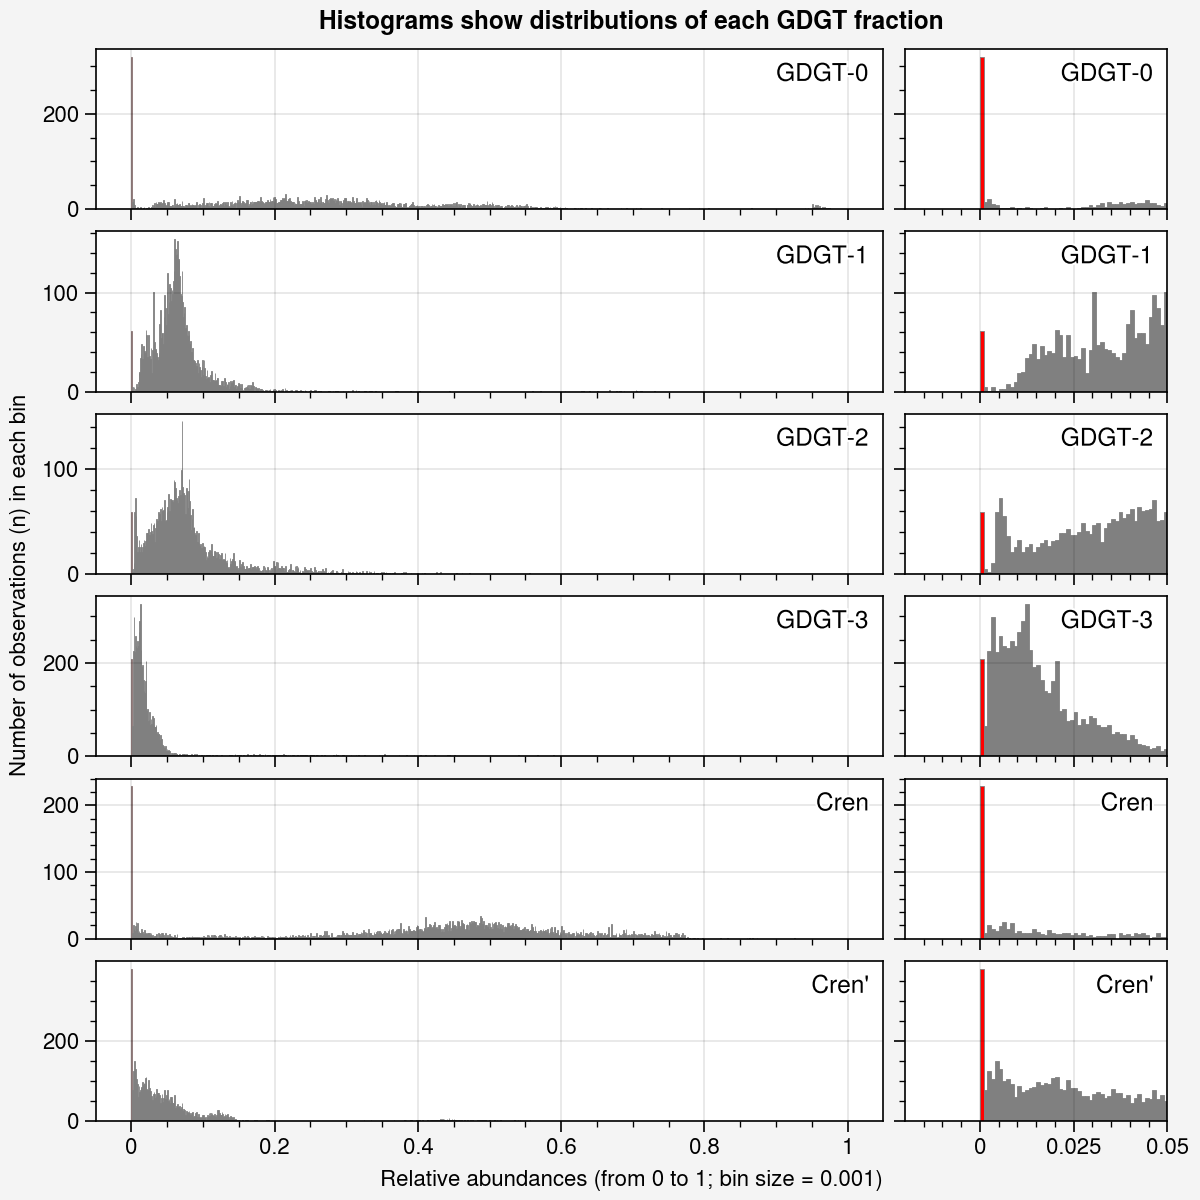

In [13]:
BDL_histogram()

**Run the code below to remove data points with abundances <= 0.001**

In [14]:
pd.set_option('display.max_rows',4,'display.max_columns',10)
df_hs = df[df.dataType_level1=='Culture - Hot spring']
#First, remove rows with too low abundaces
df_checked = df[df.dataType_level1!='Culture - Hot spring'][df.detectionLimit_check=='Pass']
frame = [df_checked,df_hs]
df2 = pd.concat(frame)
df2 = df2.reset_index()
df2 = df2.drop(columns='index')
df2.dataType_level1.unique()

array(['Mesozoic', 'Late Cenozoic', 'Culture - ThAOA', 'Water-column SPM',
       'Early Cenozoic', 'Hot spring', 'Culture - AOA', 'Core top',
       'Culture - Hot spring'], dtype=object)

## **2.2 Next, we will remove duplicate entries**

### **2.2.1 Datasets that have multiple sources will be selected from the reported newer/updated/reanalysed datasets**

**Below is an example of datasets that are duplicates of newer reported information**

In [15]:
df2[df2.duplicate_Datasets=='Yes']

,sampleName,drilling_program,Site,Site_edited,Latitude,...,firstAuthor_firstName,DOI,iGDGT-6,iGDGT-7,iGDGT-8
398,Inglis2015_1172_01,IODP-offshore,1172,"Tasman Sea, Southern Ocean",-43.9598,...,Peter,https://doi.org/10.1038/nature08399,NaN,NaN,NaN
399,Inglis2015_1172_02,IODP-offshore,1172,"Tasman Sea, Southern Ocean",-43.9598,...,Peter,https://doi.org/10.1038/nature08400,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2231,TT2015_769_54,N/A-coretop,Offshore NW Brazil; Amazon River,Western Equatorial Atlantic,0.66,...,Claudia,https://doi.org/10.1016/j.gca.2014.04.038,NaN,NaN,NaN
2232,TT2015_770_60b,N/A-coretop,Offshore NW Brazil; Amazon River,Western Equatorial Atlantic,-1.03,...,Claudia,https://doi.org/10.1016/j.gca.2014.04.038,NaN,NaN,NaN


In [16]:
df2 = df2[df2.duplicate_Datasets=='No']
df2

,sampleName,drilling_program,Site,Site_edited,Latitude,...,firstAuthor_firstName,DOI,iGDGT-6,iGDGT-7,iGDGT-8
0,Alsenz2013_Aderet1_01,Israel-onshore,Aderet 1,Aderet 1,31.6541,...,Heiko,https://doi.org/10.1016/j.palaeo.2013.09.013,NaN,NaN,NaN
1,Alsenz2013_Aderet1_02,Israel-onshore,Aderet 1,Aderet 1,31.6541,...,Heiko,https://doi.org/10.1016/j.palaeo.2013.09.013,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5759,Pearson2008_033_Pure Cultures-Desulfurococcus ...,N/A-Culture,N/A-Culture,N/A-Culture,N/A-Culture,...,Ann,https://doi.org/10.1128/AEM.02450-07,NaN,NaN,NaN
5760,Pearson2008_034_Pure Cultures-Thermoproteus uz...,N/A-Culture,N/A-Culture,N/A-Culture,N/A-Culture,...,Ann,https://doi.org/10.1128/AEM.02450-07,NaN,NaN,NaN


### **2.2.2 Datasets with multiple lipid classes**

Our data compilation contain all reported lipid classes including core lipids (CLs), intact polar lipids (IPLs), and/or total GDGTs.

For our data analysis, we prioritize total GDGTs over CLs. IPLs will be analyzed separately. If a dataset reporting lipid classes more than one types, we retain only total GDGTs in the dataframe for further analysis.

From the pivot table below, you can see that some datasets provide multiple lipid classes of GDGTs, such as Bijl et al. (2021)

In [17]:
pd.set_option('display.max_rows',10)
pivoted = df2.pivot_table(index=('Source2','dataType_level1','lipidClass'),values='gdgt23ratio',aggfunc=lambda x: len(x.unique()))
pivoted.head(10)

gdgt23ratio
Source2                 dataType_level1  lipidClass              
Alsenz et al. (2013)    Mesozoic         paleoGDGTs            95
Auderset et al. (2019)  Late Cenozoic    paleoGDGTs           194
Bale et al. (2019)      Culture - ThAOA  Total GDGTs            3
Basse et al. (2014)     Water-column SPM CL-GDGTs              83
Besseling et al. (2019) Water-column SPM CL-GDGTs              22
Bijl et al. (2021)      Early Cenozoic   paleoGDGTs           263
                        Late Cenozoic    paleoGDGTs            13
                        Mesozoic         paleoGDGTs            30
Bornemann et al. (2008) Mesozoic         paleoGDGTs            39
Bottini et al. (2015)   Mesozoic         paleoGDGTs             9

**Below is a python script to remove duplicate data entries from datasets with multiple lipid classes**

df2_main is the main dataframe that contains mainly Total GDGTs. For some datasets, CL-GDGTs will be used when the total GDGTs are not available.

In [18]:
pd.set_option('display.max_rows',8)
grouped = df2.groupby(['Source2','dataType_level1'])

interim_df = []
for i, (name, group) in enumerate(grouped):
    if len(group.lipidClass.unique())>1:
        group = group[group.lipidClass=='Total GDGTs']
    frame = pd.DataFrame(group)
    interim_df.append(frame)
new_df = pd.concat(interim_df)
new_df = new_df.reset_index()
df2_main = new_df.drop(columns='index')
df2_main

,sampleName,drilling_program,Site,Site_edited,Latitude,...,firstAuthor_firstName,DOI,iGDGT-6,iGDGT-7,iGDGT-8
0,Alsenz2013_Aderet1_01,Israel-onshore,Aderet 1,Aderet 1,31.6541,...,Heiko,https://doi.org/10.1016/j.palaeo.2013.09.013,NaN,NaN,NaN
1,Alsenz2013_Aderet1_02,Israel-onshore,Aderet 1,Aderet 1,31.6541,...,Heiko,https://doi.org/10.1016/j.palaeo.2013.09.013,NaN,NaN,NaN
2,Alsenz2013_Aderet1_03,Israel-onshore,Aderet 1,Aderet 1,31.6541,...,Heiko,https://doi.org/10.1016/j.palaeo.2013.09.013,NaN,NaN,NaN
3,Alsenz2013_Aderet1_04,Israel-onshore,Aderet 1,Aderet 1,31.6541,...,Heiko,https://doi.org/10.1016/j.palaeo.2013.09.013,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4794,vanHelmond2015_Wunstorf_44,Germany-onshore,Wunstorf,Germany,52.4031,...,Niels,https://doi.org/10.5194/cp-11-495-2015,NaN,NaN,NaN
4795,vanHelmond2015_Wunstorf_45,Germany-onshore,Wunstorf,Germany,52.4031,...,Niels,https://doi.org/10.5194/cp-11-495-2015,NaN,NaN,NaN
4796,vanHelmond2015_Wunstorf_46,Germany-onshore,Wunstorf,Germany,52.4031,...,Niels,https://doi.org/10.5194/cp-11-495-2015,NaN,NaN,NaN
4797,vanHelmond2015_Wunstorf_47,Germany-onshore,Wunstorf,Germany,52.4031,...,Niels,https://doi.org/10.5194/cp-11-495-2015,NaN,NaN,NaN


2. df2_SPM is the secondary dataframe that contains only IPL-GDGTs from all data types

In [19]:
df2_IPL = df2[df2.lipidClass=='IPL-GDGTs']
df2_IPL = df2_IPL.reset_index()
df2_IPL = df2_IPL.drop(columns='index')
df2_IPL.head(10)

,sampleName,drilling_program,Site,Site_edited,Latitude,...,firstAuthor_firstName,DOI,iGDGT-6,iGDGT-7,iGDGT-8
0,Boyd2013_026_P-GDGT_E01,N/A-HotSprings,Yellowstone NP,"Yellowstone NP, USA",44.7275,...,Eric,https://doi.org/10.3389/fmicb.2013.00062,6.4,0.5,0.3
1,Boyd2013_036_P-GDGT_E11,N/A-HotSprings,Yellowstone NP,"Yellowstone NP, USA",44.726611,...,Eric,https://doi.org/10.3389/fmicb.2013.00062,0.7,0.0,0.0
2,Boyd2013_037_P-GDGT_E12,N/A-HotSprings,Yellowstone NP,"Yellowstone NP, USA",44.304944,...,Eric,https://doi.org/10.3389/fmicb.2013.00062,0.3,0.0,0.0
3,Boyd2013_038_P-GDGT_E14,N/A-HotSprings,Yellowstone NP,"Yellowstone NP, USA",44.305222,...,Eric,https://doi.org/10.3389/fmicb.2013.00062,10.9,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
6,Boyd2013_043_P-GDGT_E22,N/A-HotSprings,Yellowstone NP,"Yellowstone NP, USA",44.304778,...,Eric,https://doi.org/10.3389/fmicb.2013.00062,0.1,0.0,0.0
7,Boyd2013_044_P-GDGT_E24,N/A-HotSprings,Yellowstone NP,"Yellowstone NP, USA",44.531833,...,Eric,https://doi.org/10.3389/fmicb.2013.00062,0.1,0.0,0.0
8,Boyd2013_045_P-GDGT_E26,N/A-HotSprings,Yellowstone NP,"Yellowstone NP, USA",44.531833,...,Eric,https://doi.org/10.3389/fmicb.2013.00062,0.1,0.0,0.0
9,Boyd2013_049_P-GDGT_E36,N/A-HotSprings,Yellowstone NP,"Yellowstone NP, USA",44.751917,...,Eric,https://doi.org/10.3389/fmicb.2013.00062,6.6,0.1,0.1


## **2.3 Then, remove GDGT data that are associated with hot springs that the pH <6.5**
In this project, we would like to compare the GDGT cyclization between marine environments and their (hyper)thermophilic counterparts. As marine AOA biosynthesize Crenarchaeol and its regioisomer (Cren') molecules, we will extract hot springs GDGTs that are coming from sites where the pH is higher than 6.5 as these archaea will not synthesize Cren and Cren' in acidic environments.

### 2.3.1 Filtering **df2_main** dataframe to **df2_main_pH**

In [20]:
pd.set_option('display.max_rows',8)
grouped = df2_main.groupby(['dataType_level1'])

interim_df = []
for i, (name, group) in enumerate(grouped):
    if name == 'Hot spring':
        group.reported_pH = group.reported_pH.replace('>7',float(7))
        group.reported_pH = pd.to_numeric(group.reported_pH,errors='coerce')
        group = group[group.reported_pH>=6.5]
    frame = pd.DataFrame(group)
    interim_df.append(frame)
new_df = pd.concat(interim_df)
new_df = new_df.reset_index()
df2_main_pH = new_df.drop(columns='index')
df2_main_pH[df2_main_pH.dataType_level1=='Hot spring'].reported_pH.unique()

array([7.17, 7.46, 8.49, 9.3, 9.1, 8.88, 8.5, 8.2, 7.0, 8.3, 7.35, 7.49,
       8.23, 8.74, 8.4, 8.6, 6.9, 6.69, 8.01, 7.12, 6.67, 6.86, 9.4, 8.0,
       7.3, 6.7, 9.2, 9.0, 9.5, 9.6, 10.1, 7.9, 7.8, 7.5, 8.8, 7.1, 6.8,
       6.6], dtype=object)

### 2.3.2 Filtering **df2_IPL** dataframe to **df2_IPL_pH**

In [21]:
pd.set_option('display.max_rows',8)
grouped = df2_IPL.groupby(['dataType_level1'])

interim_df = []
for i, (name, group) in enumerate(grouped):
    if name == 'Hot spring':
        group.reported_pH = group.reported_pH.replace('>7',float(7))
        group.reported_pH = pd.to_numeric(group.reported_pH,errors='coerce')
        group = group[group.reported_pH>=6.5]
    frame = pd.DataFrame(group)
    interim_df.append(frame)
new_df = pd.concat(interim_df)
new_df = new_df.reset_index()
df2_IPL_pH = new_df.drop(columns='index')
df2_IPL_pH[df2_IPL_pH.dataType_level1=='Hot spring'].reported_pH.unique()

array([7.46, 8.49, 9.1, 9.57, 8.88, 8.5, 8.4, 8.6, 8.2, 7.0, 6.9, 9.3,
       9.4, 8.0, 7.44, 7.3, 6.7, 7.2, 7.5, 9.5, 9.6, 8.9, 7.9, 8.1, 7.8,
       6.6, 6.8, 7.1, 8.3], dtype=object)

# **3. Import WOA18 data and generate seawater density (sigma-T)**

## 3.1 Import data

### 3.1.1 Annual average dataset from the multi-decadal climatologies (0.25degx0.25deg; 1955-2017)

In [22]:
#### Uncomment this cell if you have netcdf files in your local directory
# filepath = "C:/Users/ratta/OneDrive - Texas A&M University/Marine AOA Evolution_shared/Desktop/netcdf/"  ### change filepath to your local directory
# ts_decav_filename = 'woa18_decav_t00_04.nc'
# ts = xr.open_mfdataset(filepath+ts_decav_filename,decode_times=False,chunks={'time':1,'depth':1,'lon':100})

# ss_decav_afilname = 'woa18_decav_s00_04.nc'
# ss = xr.open_mfdataset(filepath+ss_decav_filname,decode_times=False,chunks={'time':1,'depth':1,'lon':100})

In [23]:
url = _woa_url('temperature','00','04')
ts = xr.open_dataset(url,decode_times=False,chunks={'depth':102})
ts

<xarray.Dataset>
Dimensions:             (lat: 720, nbounds: 2, lon: 1440, depth: 102, time: 1)
Coordinates:
  * lat                 (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon                 (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * depth               (depth) float32 0.0 5.0 10.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time                (time) float32 4.326e+03
Dimensions without coordinates: nbounds
Data variables:
    crs                 int32 ...
    lat_bnds            (lat, nbounds) float32 dask.array<chunksize=(720, 2), meta=np.ndarray>
    lon_bnds            (lon, nbounds) float32 dask.array<chunksize=(1440, 2), meta=np.ndarray>
    depth_bnds          (depth, nbounds) float32 dask.array<chunksize=(102, 2), meta=np.ndarray>
    climatology_bounds  (time, nbounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    t_an                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 102, 720, 1440), meta=np.ndarray>
    t_mn                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 102, 720, 1440), meta=np.ndarray>
    t_dd                (time, depth, lat, lon) float64 dask.array<chunksize=(1, 102, 720, 1440), meta=np.ndarray>
    t_sd                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 102, 720, 1440), meta=np.ndarray>
    t_se                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 102, 720, 1440), meta=np.ndarray>
    t_oa                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 102, 720, 1440), meta=np.ndarray>
    t_gp                (time, depth, lat, lon) float64 dask.array<chunksize=(1, 102, 720, 1440), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : sea_water_tempe...
    summary:                         Climatological mean temperature for the ...
    references:                      Locarnini, R. A., A. V. Mishonov, O. K. ...
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    ...                              ...
    publisher_email:                 NCEI.info@noaa.gov
    nodc_template_version:           NODC_NetCDF_Grid_Template_v2.0
    license:                         These data are openly available to the p...
    metadata_link:                   https://www.nodc.noaa.gov/OC5/woa18/
    date_created:                    2019-07-29 
    date_modified:                   2019-07-29

In [24]:
url = _woa_url('salinity','00','04')
ss = xr.open_dataset(url,decode_times=False,chunks={'depth':102})
ss

<xarray.Dataset>
Dimensions:             (lat: 720, nbounds: 2, lon: 1440, depth: 102, time: 1)
Coordinates:
  * lat                 (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon                 (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * depth               (depth) float32 0.0 5.0 10.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time                (time) float32 4.326e+03
Dimensions without coordinates: nbounds
Data variables:
    crs                 int32 ...
    lat_bnds            (lat, nbounds) float32 dask.array<chunksize=(720, 2), meta=np.ndarray>
    lon_bnds            (lon, nbounds) float32 dask.array<chunksize=(1440, 2), meta=np.ndarray>
    depth_bnds          (depth, nbounds) float32 dask.array<chunksize=(102, 2), meta=np.ndarray>
    climatology_bounds  (time, nbounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    s_an                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 102, 720, 1440), meta=np.ndarray>
    s_mn                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 102, 720, 1440), meta=np.ndarray>
    s_dd                (time, depth, lat, lon) float64 dask.array<chunksize=(1, 102, 720, 1440), meta=np.ndarray>
    s_sd                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 102, 720, 1440), meta=np.ndarray>
    s_se                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 102, 720, 1440), meta=np.ndarray>
    s_oa                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 102, 720, 1440), meta=np.ndarray>
    s_gp                (time, depth, lat, lon) float64 dask.array<chunksize=(1, 102, 720, 1440), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : sea_water_salin...
    summary:                         Climatological mean salinity for the glo...
    references:                      Zweng, M. M, J. R. Reagan, D. Seidov, T....
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    ...                              ...
    publisher_email:                 NCEI.info@noaa.gov
    nodc_template_version:           NODC_NetCDF_Grid_Template_v2.0
    license:                         These data are openly available to the p...
    metadata_link:                   https://www.nodc.noaa.gov/OC5/woa18/
    date_created:                    2019-07-30 
    date_modified:                   2019-07-30

### 3.1.2 Monthly average dataset from the multi-decadal climatologies (0.25degx0.25deg; 1955-2017)#### Uncomment this cell if you have netcdf files in your local directory

In [25]:
#### Uncomment this cell if you have netcdf files in your local directory
# filepath = "/content/drive/MyDrive/Colab Notebooks/netcdf/WOA18_monthly/" ### change filepath to your local directory
# ts_mon_filname ="woa18_decav_t*.nc"
# ts_mon = xr.open_mfdataset(filepath+ts_mon_filname,concat_dim='time',decode_times=False,combine = 'nested',chunks={'time':1,'depth':1,'lon':100})

# ss_mon_filname ="woa18_decav_s*.nc"
# ss_mon = xr.open_mfdataset(filepath+ss_mon_filname,concat_dim='time',decode_times=False,combine = 'nested', chunks={'time':1,'depth':1,'lon':100})

# mon_rng = np.linspace(1,12,12)
# ts_mon = ts_mon.update({"time":("time",mon_rng)})
# ss_mon = ss_mon.update({"time":("time",mon_rng)})

In [26]:
url_list = []
for i in range(12):
    url = _woa_url('temperature',str(i+1).zfill(2),'04') ### extracting files from 01 to 12 (January to December) from WOA18 OpenDAP url
    url_list.append(url)
url_list
ts_mon = xr.open_mfdataset(url_list,concat_dim='time',decode_times=False,combine = 'nested')
mon_rng = np.linspace(1,12,12)
ts_mon = ts_mon.update({"time":("time",mon_rng)})
ts_mon

<xarray.Dataset>
Dimensions:             (time: 12, lat: 720, nbounds: 2, lon: 1440, depth: 57)
Coordinates:
  * lat                 (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon                 (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * depth               (depth) float32 0.0 5.0 10.0 ... 1.45e+03 1.5e+03
  * time                (time) float64 1.0 2.0 3.0 4.0 ... 9.0 10.0 11.0 12.0
Dimensions without coordinates: nbounds
Data variables: (12/13)
    crs                 (time) int32 -2147483647 -2147483647 ... -2147483647
    lat_bnds            (time, lat, nbounds) float32 dask.array<chunksize=(1, 720, 2), meta=np.ndarray>
    lon_bnds            (time, lon, nbounds) float32 dask.array<chunksize=(1, 1440, 2), meta=np.ndarray>
    depth_bnds          (time, depth, nbounds) float32 dask.array<chunksize=(1, 57, 2), meta=np.ndarray>
    climatology_bounds  (time, nbounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    t_an                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 57, 720, 1440), meta=np.ndarray>
    ...                  ...
    t_dd                (time, depth, lat, lon) float64 dask.array<chunksize=(1, 57, 720, 1440), meta=np.ndarray>
    t_sd                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 57, 720, 1440), meta=np.ndarray>
    t_se                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 57, 720, 1440), meta=np.ndarray>
    t_oa                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 57, 720, 1440), meta=np.ndarray>
    t_ma                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 57, 720, 1440), meta=np.ndarray>
    t_gp                (time, depth, lat, lon) float64 dask.array<chunksize=(1, 57, 720, 1440), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : sea_water_tempe...
    summary:                         Climatological mean temperature for the ...
    references:                      Locarnini, R. A., A. V. Mishonov, O. K. ...
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    ...                              ...
    publisher_email:                 NCEI.info@noaa.gov
    nodc_template_version:           NODC_NetCDF_Grid_Template_v2.0
    license:                         These data are openly available to the p...
    metadata_link:                   https://www.nodc.noaa.gov/OC5/woa18/
    date_created:                    2019-07-29 
    date_modified:                   2019-07-29

In [27]:
url_list = []
for i in range(12):
    url = _woa_url('salinity',str(i+1).zfill(2),'04') ### extracting files from 01 to 12 (January to December) from WOA18 OpenDAP url
    url_list.append(url)
url_list
ss_mon = xr.open_mfdataset(url_list,concat_dim='time',decode_times=False,combine = 'nested',chunks={'depth':57})
mon_rng = np.linspace(1,12,12)
ss_mon = ss_mon.update({"time":("time",mon_rng)})
ss_mon

<xarray.Dataset>
Dimensions:             (time: 12, lat: 720, nbounds: 2, lon: 1440, depth: 57)
Coordinates:
  * lat                 (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon                 (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * depth               (depth) float32 0.0 5.0 10.0 ... 1.45e+03 1.5e+03
  * time                (time) float64 1.0 2.0 3.0 4.0 ... 9.0 10.0 11.0 12.0
Dimensions without coordinates: nbounds
Data variables: (12/13)
    crs                 (time) int32 -2147483647 -2147483647 ... -2147483647
    lat_bnds            (time, lat, nbounds) float32 dask.array<chunksize=(1, 720, 2), meta=np.ndarray>
    lon_bnds            (time, lon, nbounds) float32 dask.array<chunksize=(1, 1440, 2), meta=np.ndarray>
    depth_bnds          (time, depth, nbounds) float32 dask.array<chunksize=(1, 57, 2), meta=np.ndarray>
    climatology_bounds  (time, nbounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    s_an                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 57, 720, 1440), meta=np.ndarray>
    ...                  ...
    s_dd                (time, depth, lat, lon) float64 dask.array<chunksize=(1, 57, 720, 1440), meta=np.ndarray>
    s_sd                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 57, 720, 1440), meta=np.ndarray>
    s_se                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 57, 720, 1440), meta=np.ndarray>
    s_oa                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 57, 720, 1440), meta=np.ndarray>
    s_ma                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 57, 720, 1440), meta=np.ndarray>
    s_gp                (time, depth, lat, lon) float64 dask.array<chunksize=(1, 57, 720, 1440), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : sea_water_salin...
    summary:                         Climatological mean salinity for the glo...
    references:                      Zweng, M. M, J. R. Reagan, D. Seidov, T....
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    ...                              ...
    publisher_email:                 NCEI.info@noaa.gov
    nodc_template_version:           NODC_NetCDF_Grid_Template_v2.0
    license:                         These data are openly available to the p...
    metadata_link:                   https://www.nodc.noaa.gov/OC5/woa18/
    date_created:                    2019-07-30 
    date_modified:                   2019-07-30

## 3.2 Calculate seawater density (sigma-T) from imported temperture and salinity following Millero and Poission (1981)

Reference: <br>
Millero, F. J., & Poisson, A. (1981). International one-atmosphere equation of state of seawater. Deep Sea Research Part A. Oceanographic Research Papers, 28(6), 625-629.

### **3.2.1 Annual average of Sigma-T climatologies**

In [28]:
import time
start_time = time.time()
#Load t_an and s_an data
t_an_all = ts.t_an.isel(time=0).load()
s_an_all = ss.s_an.isel(time=0).load()
print("%.4f seconds" % (time.time()-start_time))

display(t_an_all)
display(s_an_all)

73.3798 seconds


<xarray.DataArray 't_an' (depth: 102, lat: 720, lon: 1440)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.64721  , -1.6448   , -1.64361  , ..., -1.64661  ,
         -1.648    , -1.64561  ],
        [-1.6447101, -1.64411  , -1.6434   , ..., -1.6447101,
         -1.64421  , -1.64361  ],
        [-1.64301  , -1.64301  , -1.64301  , ..., -1.64301  ,
         -1.64301  , -1.64301  ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
    time     float32 4.326e+03
Attributes:
    standard_name:  sea_water_temperature
    long_name:      Objectively analyzed mean fields for sea_water_temperatur...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          degrees_celsius
    _ChunkSizes:    [  1  26 180 360]

<xarray.DataArray 's_an' (depth: 102, lat: 720, lon: 1440)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [30.71261 , 30.70991 , 30.705309, ..., 30.70859 , 30.7094  ,
         30.705   ],
        [30.81641 , 30.80921 , 30.81171 , ..., 30.816309, 30.81629 ,
         30.810291],
        [30.883009, 30.883009, 30.883009, ..., 30.883009, 30.883009,
         30.883009]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
    time     float32 4.326e+03
Attributes:
    standard_name:  sea_water_salinity
    long_name:      Objectively analyzed mean fields for sea_water_salinity a...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          1e-3
    _ChunkSizes:    [  1  26 180 360]

In [31]:
#Load t_an and s_an data
t_an_all = ts.t_an.isel(time=0)
s_an_all = ss.s_an.isel(time=0)

sel_t = t_an_all
sel_s = s_an_all

sigma_all=sigmaT_cal_Miller_and_Poisson_1981(sel_t,sel_s)
sigma_all=sigma_all.chunk(chunks={'depth':10})
sigma_all_local=sigma_all
print("%.4f seconds" % (time.time()-start_time))
sigma_all_local

120.9294 seconds


<xarray.DataArray (depth: 102, lat: 720, lon: 1440)>
dask.array<rechunk-merge, shape=(102, 720, 1440), dtype=float32, chunksize=(10, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
    time     float32 4.326e+03

### **3.2.2 Monthly average of Sigma-T climatologies**

In [32]:
#Load t_an and s_an data
t_an_all_mon = ts_mon.t_an
s_an_all_mon = ss_mon.s_an

sel_t = t_an_all_mon
sel_s = s_an_all_mon

start_time = time.time()
sigma_all_mon=sigmaT_cal_Miller_and_Poisson_1981(sel_t,sel_s)
sigma_all_mon=sigma_all_mon.chunk(chunks={'depth':57,'time':2})
sigma_all_mon_local=sigma_all_mon
print("%.4f seconds" % (time.time()-start_time))
sigma_all_mon_local

0.2746 seconds


<xarray.DataArray (time: 12, depth: 57, lat: 720, lon: 1440)>
dask.array<rechunk-merge, shape=(12, 57, 720, 1440), dtype=float32, chunksize=(2, 57, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 1.4e+03 1.45e+03 1.5e+03
  * time     (time) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0

### **3.2.3 Standard deviation volution of monthly average of Sigma-T climatologies**

In [33]:
start_time = time.time()
sigma_mon_std_local = sigma_all_mon_local.std(dim='time')
sigma_mon_std_local = sigma_mon_std_local.chunk(chunks={'depth':10})
print("%.4f seconds" % (time.time()-start_time))
sigma_mon_std_local

0.1496 seconds


<xarray.DataArray (depth: 57, lat: 720, lon: 1440)>
dask.array<rechunk-merge, shape=(57, 720, 1440), dtype=float32, chunksize=(10, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 1.4e+03 1.45e+03 1.5e+03

# **4. Import paleowater depth gridded data from PaleoDEMS project (Scotese and Wright, 2018)**

Reference:<br>
Scotese, C. R., & Wright, N. (2018). PALEOMAP Paleodigital Elevation Models (PaleoDEMS) for the Phanerozoic PALEOMAP Project.

Resource:<br>
https://www.earthbyte.org/paleodem-resource-scotese-and-wright-2018/

In [30]:
# filepath = "/content/drive/MyDrive/Colab Notebooks/paleoDEMS/"
filepath = "C:/Users/ratta/working-repo/paleoDEMS/Scotese_Wright_2018_Maps_1-88_6minX6min_PaleoDEMS_nc/"
filename = "PaleoDEMS_elevation_Scotese_Wright_2018.nc"

ds_paleoDEM = xr.open_mfdataset(filepath+filename)
ds_paleoDEM.elev.values = ds_paleoDEM.elev.values*(-1)
ds_paleoDEM

<xarray.Dataset>
Dimensions:  (geoAge: 109, lat: 181, lon: 361)
Coordinates:
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
  * geoAge   (geoAge) int32 0 5 10 15 20 25 30 ... 510 515 520 525 530 535 540
Data variables:
    elev     (lat, lon, geoAge) float64 -0.0 -0.0 -40.0 ... 3.48e+03 3.48e+03

# **5. Reconstruct paleolatitude and paleolongitude**

In [31]:
rot_filepath="C:/Users/ratta/marine-AOA-GDGT-distribution/paleoDEMS/pyGplates_files/PaleoDEMS_global_plate_model/"
rot_filename="m06c9h_3id_forPgeog_19o_r1c.rot"
rotation_model = pygplates.RotationModel(rot_filepath+rot_filename)

poly_filepath="C:/Users/ratta/marine-AOA-GDGT-distribution/paleoDEMS/pyGplates_files/PaleoDEMS_global_plate_model/"
statPoly_filename="PALEOMAP_PlatePolygons__forPgeog_v19o.gpml"
static_polygons = pygplates.FeatureCollection(poly_filepath+statPoly_filename)


## **5.1 Reconstruct paleolat/paleolon for df2_main_pH**

In [32]:
from tqdm import tqdm

import time
start_time = time.time()

df2_main_pH['paleolat'], df2_main_pH['paleolon'] = np.nan, np.nan
grouped = df2_main_pH[['sampleID_new','Latitude','Longitude','paleolat','paleolon','dataType_level0','sampleAge']].groupby('dataType_level0')


interim_df = []
for name, group in grouped:
    print(name)
    if name == 'Ancient':
        group = group.dropna(how='any',subset=['Latitude','Longitude'])
        for i in tqdm(range(len(group.Latitude))):

            point = pygplates.PointOnSphere(float(group.Latitude.iloc[i]),float(group.Longitude.iloc[i]))
            point_feature = pygplates.Feature()
            point_feature.set_geometry(point)

            #Assign a point into an associated plate based on modern-day location, rotation files, etc.
            partitioned_point_features = pygplates.partition_into_plates(static_polygons,
                                                                   rotation_model,
                                                                   point_feature) 



            # Reconstruct the points to sampleAge
            reconstructed_point_features = []
            pygplates.reconstruct(partitioned_point_features,
                                  rotation_model,
                                  reconstructed_point_features,
                                  group.sampleAge.iloc[i])

            point = reconstructed_point_features[0].get_reconstructed_geometry()
            latitude, longitude = point.to_lat_lon()

            group.paleolat.iloc[i] = np.round(latitude,decimals=5)
            group.paleolon.iloc[i] = np.round(longitude,decimals=5)

            # print("--- %s seconds ---" % np.round(time.time() - start_time,decimals=5))
            # print(f"--- %s / {len(group.iloc[:,0])-1}  ---" % i)

    else:
        group.paleolat = group.Latitude
        group.paleolon = group.Longitude
    frame = pd.DataFrame(group)
    interim_df.append(frame)
new_df = pd.concat(interim_df)
print("%.4f seconds" % (time.time() - start_time))
new_df

Ancient


100%|██████████████████████████████████████████████████████████████████████████████| 3132/3132 [01:26<00:00, 36.26it/s]


Culture
Modern
93.7426 seconds


,sampleID_new,Latitude,Longitude,paleolat,paleolon,dataType_level0,sampleAge
996,RR00609,-43.9598,149.9283,-61.57823,154.17239,Ancient,34.5900
997,RR00610,-43.9598,149.9283,-61.67238,154.35585,Ancient,34.9340
998,RR00611,-43.9598,149.9283,-61.88209,154.77684,Ancient,35.7111
999,RR00612,-43.9598,149.9283,-61.89162,154.79637,Ancient,35.7467
...,...,...,...,...,...,...,...
4776,RR06736,13,-105,13,-105,Modern,0.0000
4777,RR06737,13,-105,13,-105,Modern,0.0000
4778,RR06738,13,-105,13,-105,Modern,0.0000
4779,RR06739,13,-105,13,-105,Modern,0.0000


**Matching the lookup values from pyGplates reconstruction to dataframe df2_main_pH**

In [33]:
paleolat_dict = dict(zip(new_df.sampleID_new,new_df.paleolat))
paleolon_dict = dict(zip(new_df.sampleID_new,new_df.paleolon))

df2_main_pH['paleolat'] = df2_main_pH['sampleID_new'].map(paleolat_dict)
df2_main_pH['paleolon'] = df2_main_pH['sampleID_new'].map(paleolon_dict)
df2_main_pH[['paleolat','paleolon']]

,paleolat,paleolon
0,-40.0032,0.9075
1,-34.6213,17.0363
2,-36.4956,13.1091
3,-34.3263,17.9736
...,...,...
4776,13,-105
4777,13,-105
4778,13,-105
4779,13,-105


In [34]:
from tqdm import tqdm

import time
start_time = time.time()

df2_IPL_pH['paleolat'], df2_IPL_pH['paleolon'] = np.nan, np.nan
grouped = df2_IPL_pH[['sampleID_new','Latitude','Longitude','paleolat','paleolon','dataType_level0','sampleAge']].groupby('dataType_level0')


interim_df = []
for name, group in grouped:
    if name == 'Ancient':
        group = group.dropna(how='any',subset=['Latitude','Longitude'])
        for i in tqdm(range(len(group.Latitude))):
            point = pygplates.PointOnSphere(float(group.Latitude.iloc[i]),float(group.Longitude.iloc[i]))
            point_feature = pygplates.Feature()
            point_feature.set_geometry(point)

            #Assign a point into an associated plate based on modern-day location, rotation files, etc.
            partitioned_point_features = pygplates.partition_into_plates(static_polygons,
                                                                   rotation_model,
                                                                   point_feature) 



            # Reconstruct the points to sampleAge
            reconstructed_point_features = []
            pygplates.reconstruct(partitioned_point_features,
                                  rotation_model,
                                  reconstructed_point_features,
                                  group.sampleAge.iloc[i])

            point = reconstructed_point_features[0].get_reconstructed_geometry()
            latitude, longitude = point.to_lat_lon()

            group.paleolat.iloc[i] = np.round(latitude,decimals=5)
            group.paleolon.iloc[i] = np.round(longitude,decimals=5)
            print(latitude)
                
            # print("--- %s seconds ---" % np.round(time.time() - start_time,decimals=5))
            # print(f"--- %s / {len(group.iloc[:,0])-1}  ---" % i)

    else:
        group.paleolat = group.Latitude
        group.paleolon = group.Longitude
    frame = pd.DataFrame(group)
    interim_df.append(frame)
new_df = pd.concat(interim_df)
new_df

,sampleID_new,Latitude,Longitude,paleolat,paleolon,dataType_level0,sampleAge
34,RR01383,N/A-Culture,N/A-Culture,N/A-Culture,N/A-Culture,Culture,0.0
35,RR01386,N/A-Culture,N/A-Culture,N/A-Culture,N/A-Culture,Culture,0.0
36,RR01387,N/A-Culture,N/A-Culture,N/A-Culture,N/A-Culture,Culture,0.0
37,RR01388,N/A-Culture,N/A-Culture,N/A-Culture,N/A-Culture,Culture,0.0
...,...,...,...,...,...,...,...
301,RR06553,13,-105,13,-105,Modern,0.0
302,RR06557,13,-105,13,-105,Modern,0.0
303,RR06562,13,-105,13,-105,Modern,0.0
304,RR06563,13,-105,13,-105,Modern,0.0


**Matching the lookup values from pyGplates reconstruction to dataframe df2_IPL_pH (no values matched as no IPL fractions in paleodata)**

In [35]:
paleolat_dict = dict(zip(new_df.sampleID_new,new_df.paleolat))
paleolon_dict = dict(zip(new_df.sampleID_new,new_df.paleolon))

df2_IPL_pH['paleolat'] = df2_IPL_pH['sampleID_new'].map(paleolat_dict)
df2_IPL_pH['paleolon'] = df2_IPL_pH['sampleID_new'].map(paleolon_dict)
df2_IPL_pH

,sampleName,drilling_program,Site,Site_edited,Latitude,...,iGDGT-6,iGDGT-7,iGDGT-8,paleolat,paleolon
0,Kim2016_004_coretop_64PE332-7_2_BD_IPL,N/A-SPM,Portuguese Continental Margin,Temperate Eastern Atlantic,41.13,...,NaN,NaN,NaN,41.13,-9.085
1,Kim2016_008_coretop_64PE332-6_1_BD_IPL,N/A-SPM,Portuguese Continental Margin,Temperate Eastern Atlantic,41.135,...,NaN,NaN,NaN,41.135,-9.345
2,Kim2016_011_coretop_64PE332-5_2_BD_IPL,N/A-SPM,Portuguese Continental Margin,Temperate Eastern Atlantic,41.132,...,NaN,NaN,NaN,41.132,-9.371
3,Kim2016_014_coretop_64PE332-4_1_BD_IPL,N/A-SPM,Portuguese Continental Margin,Temperate Eastern Atlantic,38.417,...,NaN,NaN,NaN,38.417,-9.062
...,...,...,...,...,...,...,...,...,...,...,...
301,Zhu2016_318_IPL_ETNP_ST2_400,N/A-SPM,ETNP,ETNP,13,...,NaN,NaN,NaN,13,-105
302,Zhu2016_322_IPL_ETNP_ST5_600,N/A-SPM,ETNP,ETNP,13,...,NaN,NaN,NaN,13,-105
303,Zhu2016_327_IPL_ETNP_ST8_50,N/A-SPM,ETNP,ETNP,13,...,NaN,NaN,NaN,13,-105
304,Zhu2016_328_IPL_ETNP_ST8_125,N/A-SPM,ETNP,ETNP,13,...,NaN,NaN,NaN,13,-105


# **6. Matching water properties and paleo-water depth to database**

## **6.1 Matching Paleo-water Depth from PaleoDEMS project**

In [36]:
### Variables that we will match from WOA18
df2_main_pH['WOA18_decav_insituT'] = np.nan
df2_main_pH['WOA18_decav_SST'] = np.nan
df2_main_pH['WOA18_decav_insituS'] = np.nan
df2_main_pH['WOA18_decav_SSS'] = np.nan 

df2_main_pH['WOA18_decav_insitu_sigmaT'] = np.nan
df2_main_pH['WOA18_decav_surface_sigmaT'] = np.nan
df2_main_pH['WOA18_decav_insitu_sigmaT_std'] = np.nan


df2_main_pH['match_depth'] = np.nan
df2_main_pH['match_age'] = np.nan
df2_main_pH['match_lat'] = np.nan
df2_main_pH['match_lon'] = np.nan

df2_main_pH['oceanLayer_class'] = np.nan

df2_main_pH['paleoWaterDepth'] = np.nan

In [37]:
#loop to get data
import time
start_time = time.time()
interim_df=[]
grouped = df2_main_pH.groupby(['dataType_level0','dataType_level1'])
for j, (name,group) in enumerate(grouped):
    if name[0] == 'Ancient':
        for i in tqdm(range(len(group.paleolat))):
            match_lat = group.paleolat.iloc[i]
            match_lon = group.paleolon.iloc[i]
            match_age = group.sampleAge.iloc[i]
            if (np.isnan(match_lat)|np.isnan(match_lon)|np.isnan(match_age)):
                continue
            else:
                group.paleoWaterDepth.iloc[i] = ds_paleoDEM.elev.sel(lat=match_lat,
                                                                     lon=match_lon,
                                                                     geoAge=match_age,
                                                                     method='nearest').data
                

    elif ((name[0] == 'Modern')&((name[1]=='Core top')|(name[1]=='Water-column SPM'))):
       
        group.paleoWaterDepth = group.modernWaterDepth        

    frame = pd.DataFrame(group)
    interim_df.append(frame)
new_df = pd.concat(interim_df)
df2_main_pH = new_df
print("--- %s seconds ---" % (time.time() - start_time))
df2_main_pH

100%|███████████████████████████████████████████████████████████████████████████████| 869/869 [00:01<00:00, 477.10it/s]


--- 6.760655164718628 seconds ---


,sampleName,drilling_program,Site,Site_edited,Latitude,...,match_age,match_lat,match_lon,oceanLayer_class,paleoWaterDepth
996,Bijl2021_014_1172D_2R-5W_140.5_,IODP-offshore,1172,"Tasman Sea, Southern Ocean",-43.9598,...,NaN,NaN,NaN,NaN,2720.0
997,Bijl2021_015_1172D_2R-6W_44545_,IODP-offshore,1172,"Tasman Sea, Southern Ocean",-43.9598,...,NaN,NaN,NaN,NaN,2720.0
998,Bijl2021_016_1172D_2R-6W_62.5-65.5_,IODP-offshore,1172,"Tasman Sea, Southern Ocean",-43.9598,...,NaN,NaN,NaN,NaN,3080.0
999,Bijl2021_017_1172D_2R-6W_85-89_,IODP-offshore,1172,"Tasman Sea, Southern Ocean",-43.9598,...,NaN,NaN,NaN,NaN,3080.0
...,...,...,...,...,...,...,...,...,...,...,...
4776,Zhu2016_501_totalGDGTs_ETNP_ST8_650,N/A-SPM,ETNP,ETNP,13,...,NaN,NaN,NaN,NaN,650
4777,Zhu2016_502_totalGDGTs_ETNP_ST8_750,N/A-SPM,ETNP,ETNP,13,...,NaN,NaN,NaN,NaN,750
4778,Zhu2016_503_totalGDGTs_ETNP_ST8_1000,N/A-SPM,ETNP,ETNP,13,...,NaN,NaN,NaN,NaN,1000
4779,Zhu2016_504_totalGDGTs_ETNP_ST8_1250,N/A-SPM,ETNP,ETNP,13,...,NaN,NaN,NaN,NaN,1250


## **6.2 Matching modern seawater properties from WOA18 to dataframe**

In [38]:
start_time = time.time()
modern_subset_df = df2_main_pH[(df2_main_pH.dataType_level1=='Core top')|(df2_main_pH.dataType_level1=='Water-column SPM')]
features = ['sampleID_new','Latitude','Longitude','modernWaterDepth','match_lat','match_lon','match_depth',
            'WOA18_decav_insituT','WOA18_decav_SST','WOA18_decav_insituS','WOA18_decav_SSS',
           'WOA18_decav_insitu_sigmaT','WOA18_decav_surface_sigmaT','WOA18_decav_insitu_sigmaT_std','oceanLayer_class']
modern_subset_df = modern_subset_df[features]

WOA18_depth_array = ts.t_an.depth.data
WOA18_lat_array = ts.t_an.lat.data
WOA18_lon_array = ts.t_an.lon.data

####first, we create match_lat, match_lon, match_depth columns into dataframe 
####(this will reduce the interpolation time when we select/slice xarray datasets)
for i in tqdm(range(len(modern_subset_df.sampleID_new))):
    modern_subset_df.match_lat.iloc[i] = WOA18_lat_array[np.abs(WOA18_lat_array - modern_subset_df.Latitude.iloc[i]).argmin()]
    modern_subset_df.match_lon.iloc[i] = WOA18_lon_array[np.abs(WOA18_lon_array - modern_subset_df.Longitude.iloc[i]).argmin()]
    modern_subset_df.match_depth.iloc[i] = WOA18_depth_array[np.abs(WOA18_depth_array - modern_subset_df.modernWaterDepth.iloc[i]).argmin()]


grouped = modern_subset_df.where(modern_subset_df.modernWaterDepth!= -999).groupby(['match_depth','match_lon'])

interim_df = []
for i, (name, group) in enumerate(tqdm(grouped)):
    t_an_temp1 = t_an_all.sel(depth=name[0])
    s_an_temp1 = s_an_all.sel(depth=name[0])
    sigmaT_temp1 = sigma_all_local.sel(depth=name[0])
    
    t_an_surface = t_an_all.sel(depth=0)
    s_an_surface = s_an_all.sel(depth=0)
    sigmaT_surface = sigma_all_local.sel(depth=0)
    if name[0] <= 1500:
        sigmaT_mon_std_temp1 = sigma_mon_std_local.sel(depth=name[0])
        sigmaT_mon_std_surface = sigma_mon_std_local.sel(depth=0)
    
    interim_data = group.reset_index()
    interim_data = interim_data.iloc[:,1:]

    for j in range(len(interim_data.sampleID_new)):
        t_an_temp2 = t_an_temp1.sel(lon=name[1])
        s_an_temp2 = s_an_temp1.sel(lon=name[1])
        sigmaT_temp2 = sigmaT_temp1.sel(lon=name[1])
        sigmaT_mon_std_temp2 = sigmaT_mon_std_temp1.sel(lon=name[1])
        
        t_an_surface_temp2 = t_an_surface.sel(lon=name[1])
        s_an_surface_temp2 = s_an_surface.sel(lon=name[1])
        sigmaT_surface_temp2 = sigmaT_surface.sel(lon=name[1])
        sigmaT_mon_surface_std_temp2 = sigmaT_mon_std_surface.sel(lon=name[1])
        
        group.WOA18_decav_insituT.iloc[j] = t_an_temp2.sel(lat=interim_data.match_lat.iloc[j]).values
        group.WOA18_decav_insituS.iloc[j] = s_an_temp2.sel(lat=interim_data.match_lat.iloc[j]).values
        if modern_subset_df.match_depth.iloc[i] <= 1500:
            group.WOA18_decav_insitu_sigmaT.iloc[j] = sigmaT_temp2.sel(lat=interim_data.match_lat.iloc[j]).values
            group.WOA18_decav_insitu_sigmaT_std.iloc[j] = sigmaT_mon_std_temp2.sel(lat=interim_data.match_lat.iloc[j]).values
        
        group.WOA18_decav_SST.iloc[j] = t_an_surface_temp2.sel(lat=interim_data.match_lat.iloc[j]).values
        group.WOA18_decav_SSS.iloc[j] = s_an_surface_temp2.sel(lat=interim_data.match_lat.iloc[j]).values
        group.WOA18_decav_surface_sigmaT.iloc[j] = sigmaT_surface_temp2.sel(lat=interim_data.match_lat.iloc[j]).values
    frame = pd.DataFrame(group)
    interim_df.append(frame)
new_df_modern = pd.concat(interim_df)
display(new_df_modern)
print("--- %s seconds ---" % (time.time() - start_time))

100%|█████████████████████████████████████████████████████████████████████████████▉| 1245/1246 [01:03<00:00, 19.58it/s]


,sampleID_new,Latitude,Longitude,modernWaterDepth,match_lat,...,WOA18_decav_SSS,WOA18_decav_insitu_sigmaT,WOA18_decav_surface_sigmaT,WOA18_decav_insitu_sigmaT_std,oceanLayer_class
945,RR06234,3.07,-47.64,0,3.125,...,36.001301,NaN,23.340332,NaN,NaN
4497,RR05564,41.14,-9.61,1,41.125,...,35.730099,NaN,26.251465,NaN,NaN
4492,RR05559,41.13,-9.37,1,41.125,...,35.684410,NaN,26.228760,NaN,NaN
4502,RR05569,38.61,-9.36,1,38.625,...,35.819012,NaN,26.243286,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
394,RR01821,-44.207,-51.423,5691,-44.125,...,34.659588,27.825195,26.083008,0.008161,NaN
493,RR01920,-4.032,-25.623,5521,-4.125,...,36.043400,NaN,23.541565,0.005335,NaN
46,RR02134,79.1336,2.8424,5571,79.125,...,34.497501,28.069824,27.588623,0.003904,NaN
110,RR02203,38.8917,157.6282,5535,38.875,...,34.286713,27.758179,25.229126,0.006215,NaN


--- 67.0814619064331 seconds ---


In [39]:
#selected features to be mapped to the main dataframe
features = ['match_lat','match_lon','match_depth',
            'WOA18_decav_insituT','WOA18_decav_SST','WOA18_decav_insituS','WOA18_decav_SSS',
           'WOA18_decav_insitu_sigmaT','WOA18_decav_surface_sigmaT','WOA18_decav_insitu_sigmaT_std']

for i in tqdm(range(len(features))):
    match_dict = dict(zip(new_df_modern.sampleID_new,new_df_modern[features[i]]))

    df2_main_pH[features[i]] = df2_main_pH['sampleID_new'].map(match_dict)
df2_main_pH[df2_main_pH.dataType_level0=='Modern']

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 399.92it/s]


,sampleName,drilling_program,Site,Site_edited,Latitude,...,match_age,match_lat,match_lon,oceanLayer_class,paleoWaterDepth
0,TT2015_529_D357 St. 6,N/A-coretop,"SE Atlantic, offshore South Africa",SE Atlantic,-40.0032,...,NaN,-40.125,0.875,NaN,4928
1,TT2015_530_D357 St. 1,N/A-coretop,"SE Atlantic, offshore South Africa",Eastern South Atlantic,-34.6213,...,NaN,-34.625,17.125,NaN,2620
2,TT2015_531_D357 St. 3,N/A-coretop,"SE Atlantic, offshore South Africa",SE Atlantic,-36.4956,...,NaN,-36.375,13.125,NaN,4900
3,TT2015_532_D357 St. 8,N/A-coretop,"SE Atlantic, offshore South Africa",Eastern South Atlantic,-34.3263,...,NaN,-34.375,17.875,NaN,733
...,...,...,...,...,...,...,...,...,...,...,...
4776,Zhu2016_501_totalGDGTs_ETNP_ST8_650,N/A-SPM,ETNP,ETNP,13,...,NaN,12.875,-105.125,NaN,650
4777,Zhu2016_502_totalGDGTs_ETNP_ST8_750,N/A-SPM,ETNP,ETNP,13,...,NaN,12.875,-105.125,NaN,750
4778,Zhu2016_503_totalGDGTs_ETNP_ST8_1000,N/A-SPM,ETNP,ETNP,13,...,NaN,12.875,-105.125,NaN,1000
4779,Zhu2016_504_totalGDGTs_ETNP_ST8_1250,N/A-SPM,ETNP,ETNP,13,...,NaN,12.875,-105.125,NaN,1250


## **6.3 Ocean layer classification**

In [40]:
for i in tqdm(range(len(df2_main_pH.sampleID_new))):
    if ((df2_main_pH.dataType_level1.iloc[i] == 'Core top') | (df2_main_pH.dataType_level1.iloc[i] == 'Water-column SPM')):
        selected_insitu_sigmaSTD = df2_main_pH.WOA18_decav_insitu_sigmaT_std
        if df2_main_pH.modernWaterDepth.iloc[i] > 100:
            if selected_insitu_sigmaSTD.iloc[i] >= 0.1:
                df2_main_pH['oceanLayer_class'].iloc[i] = "Surface ocean"
            elif np.isnan(selected_insitu_sigmaSTD.iloc[i])==True:
                df2_main_pH['oceanLayer_class'].iloc[i] = "Deep ocean"
            else:
                df2_main_pH['oceanLayer_class'].iloc[i] = "Deep ocean"


        elif df2_main_pH.modernWaterDepth.iloc[i]  <= 100:
            if selected_insitu_sigmaSTD.iloc[i] < 0.1:
                df2_main_pH['oceanLayer_class'].iloc[i] = "Deep ocean"
            elif np.isnan(selected_insitu_sigmaSTD.iloc[i])==True:
                df2_main_pH['oceanLayer_class'].iloc[i] = "Surface ocean"
            else:
                df2_main_pH['oceanLayer_class'].iloc[i] = "Surface ocean"


100%|████████████████████████████████████████████████████████████████████████████| 4780/4780 [00:00<00:00, 9285.41it/s]


In [41]:
df2_main_pH

,sampleName,drilling_program,Site,Site_edited,Latitude,...,match_age,match_lat,match_lon,oceanLayer_class,paleoWaterDepth
996,Bijl2021_014_1172D_2R-5W_140.5_,IODP-offshore,1172,"Tasman Sea, Southern Ocean",-43.9598,...,NaN,NaN,NaN,NaN,2720.0
997,Bijl2021_015_1172D_2R-6W_44545_,IODP-offshore,1172,"Tasman Sea, Southern Ocean",-43.9598,...,NaN,NaN,NaN,NaN,2720.0
998,Bijl2021_016_1172D_2R-6W_62.5-65.5_,IODP-offshore,1172,"Tasman Sea, Southern Ocean",-43.9598,...,NaN,NaN,NaN,NaN,3080.0
999,Bijl2021_017_1172D_2R-6W_85-89_,IODP-offshore,1172,"Tasman Sea, Southern Ocean",-43.9598,...,NaN,NaN,NaN,NaN,3080.0
...,...,...,...,...,...,...,...,...,...,...,...
4776,Zhu2016_501_totalGDGTs_ETNP_ST8_650,N/A-SPM,ETNP,ETNP,13,...,NaN,12.875,-105.125,Deep ocean,650
4777,Zhu2016_502_totalGDGTs_ETNP_ST8_750,N/A-SPM,ETNP,ETNP,13,...,NaN,12.875,-105.125,Deep ocean,750
4778,Zhu2016_503_totalGDGTs_ETNP_ST8_1000,N/A-SPM,ETNP,ETNP,13,...,NaN,12.875,-105.125,Deep ocean,1000
4779,Zhu2016_504_totalGDGTs_ETNP_ST8_1250,N/A-SPM,ETNP,ETNP,13,...,NaN,12.875,-105.125,Deep ocean,1250


**Do the same for IPL dataset**

In [42]:
### Variables that we will match from WOA18
df2_IPL_pH['WOA18_decav_insituT'] = np.nan
df2_IPL_pH['WOA18_decav_SST'] = np.nan
df2_IPL_pH['WOA18_decav_insituS'] = np.nan
df2_IPL_pH['WOA18_decav_SSS'] = np.nan 

df2_IPL_pH['WOA18_decav_insitu_sigmaT'] = np.nan
df2_IPL_pH['WOA18_decav_surface_sigmaT'] = np.nan
df2_IPL_pH['WOA18_decav_insitu_sigmaT_std'] = np.nan

df2_IPL_pH['match_depth'] = np.nan
df2_IPL_pH['match_lat'] = np.nan
df2_IPL_pH['match_lon'] = np.nan
df2_IPL_pH['oceanLayer_class'] = np.nan

df2_IPL_pH['paleoWaterDepth'] = np.nan

In [43]:
#loop to get data
import time
start_time = time.time()
interim_df=[]
grouped = df2_IPL_pH.groupby(['dataType_level0','dataType_level1'])
for j, (name,group) in enumerate(grouped):
    if name[0] == 'Ancient':
        for i in tqdm(range(len(group.paleolat))):
            match_lat = group.paleolat.iloc[i]
            match_lon = group.paleolon.iloc[i]
            match_age = group.sampleAge.iloc[i]
            if (np.isnan(match_lat)|np.isnan(match_lon)|np.isnan(match_age)):
                continue
            else:
                group.paleoWaterDepth.iloc[i] = ds_paleoDEM.elev.sel(lat=match_lat,
                                                                     lon=match_lon,
                                                                     geoAge=match_age,
                                                                     method='nearest').data
                

    elif ((name[0] == 'Modern')&((name[1]=='Core top')|(name[1]=='Water-column SPM'))):
       
        group.paleoWaterDepth = group.modernWaterDepth        

    frame = pd.DataFrame(group)
    interim_df.append(frame)
new_df = pd.concat(interim_df)
df2_IPL_pH = new_df
print("--- %s seconds ---" % (time.time() - start_time))
df2_IPL_pH

--- 0.06701493263244629 seconds ---


,sampleName,drilling_program,Site,Site_edited,Latitude,...,match_depth,match_lat,match_lon,oceanLayer_class,paleoWaterDepth
34,Elling2017_culture_marineAOA_total_IPLs_Nitros...,N/A-Culture,N/A-Culture,N/A-Culture,N/A-Culture,...,NaN,NaN,NaN,NaN,NaN
35,Elling2017_culture_marineAOA_total_IPLs_Strain...,N/A-Culture,N/A-Culture,N/A-Culture,N/A-Culture,...,NaN,NaN,NaN,NaN,NaN
36,Elling2017_culture_marineAOA_total_IPLs_Strain...,N/A-Culture,N/A-Culture,N/A-Culture,N/A-Culture,...,NaN,NaN,NaN,NaN,NaN
37,Elling2017_culture_ThAOA_total_IPLs_Nitrososph...,N/A-Culture,N/A-Culture,N/A-Culture,N/A-Culture,...,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
301,Zhu2016_318_IPL_ETNP_ST2_400,N/A-SPM,ETNP,ETNP,13,...,NaN,NaN,NaN,NaN,400
302,Zhu2016_322_IPL_ETNP_ST5_600,N/A-SPM,ETNP,ETNP,13,...,NaN,NaN,NaN,NaN,600
303,Zhu2016_327_IPL_ETNP_ST8_50,N/A-SPM,ETNP,ETNP,13,...,NaN,NaN,NaN,NaN,50
304,Zhu2016_328_IPL_ETNP_ST8_125,N/A-SPM,ETNP,ETNP,13,...,NaN,NaN,NaN,NaN,125


In [44]:
start_time = time.time()
modern_subset_df = df2_IPL_pH[(df2_IPL_pH.dataType_level1=='Core top')|(df2_IPL_pH.dataType_level1=='Water-column SPM')]
features = ['sampleID_new','Latitude','Longitude','modernWaterDepth','match_lat','match_lon','match_depth',
            'WOA18_decav_insituT','WOA18_decav_SST','WOA18_decav_insituS','WOA18_decav_SSS',
           'WOA18_decav_insitu_sigmaT','WOA18_decav_surface_sigmaT','WOA18_decav_insitu_sigmaT_std','oceanLayer_class']
modern_subset_df = modern_subset_df[features]

WOA18_depth_array = ts.t_an.depth.data
WOA18_lat_array = ts.t_an.lat.data
WOA18_lon_array = ts.t_an.lon.data

####first, we create match_lat, match_lon, match_depth columns into dataframe 
####(this will reduce the interpolation time when we select/slice xarray datasets)
for i in tqdm(range(len(modern_subset_df.sampleID_new))):
    modern_subset_df.match_lat.iloc[i] = WOA18_lat_array[np.abs(WOA18_lat_array - modern_subset_df.Latitude.iloc[i]).argmin()]
    modern_subset_df.match_lon.iloc[i] = WOA18_lon_array[np.abs(WOA18_lon_array - modern_subset_df.Longitude.iloc[i]).argmin()]
    modern_subset_df.match_depth.iloc[i] = WOA18_depth_array[np.abs(WOA18_depth_array - modern_subset_df.modernWaterDepth.iloc[i]).argmin()]


grouped = modern_subset_df.where(modern_subset_df.modernWaterDepth!= -999).groupby(['match_depth','match_lon'])

interim_df = []
for i, (name, group) in enumerate(tqdm(grouped)):
    t_an_temp1 = t_an_all.sel(depth=name[0])
    s_an_temp1 = s_an_all.sel(depth=name[0])
    sigmaT_temp1 = sigma_all_local.sel(depth=name[0])
    
    t_an_surface = t_an_all.sel(depth=0)
    s_an_surface = s_an_all.sel(depth=0)
    sigmaT_surface = sigma_all_local.sel(depth=0)
    if name[0] <= 1500:
        sigmaT_mon_std_temp1 = sigma_mon_std_local.sel(depth=name[0])
        sigmaT_mon_std_surface = sigma_mon_std_local.sel(depth=0)
    
    interim_data = group.reset_index()
    interim_data = interim_data.iloc[:,1:]

    for j in range(len(interim_data.sampleID_new)):
        t_an_temp2 = t_an_temp1.sel(lon=name[1])
        s_an_temp2 = s_an_temp1.sel(lon=name[1])
        sigmaT_temp2 = sigmaT_temp1.sel(lon=name[1])
        sigmaT_mon_std_temp2 = sigmaT_mon_std_temp1.sel(lon=name[1])
        
        t_an_surface_temp2 = t_an_surface.sel(lon=name[1])
        s_an_surface_temp2 = s_an_surface.sel(lon=name[1])
        sigmaT_surface_temp2 = sigmaT_surface.sel(lon=name[1])
        sigmaT_mon_surface_std_temp2 = sigmaT_mon_std_surface.sel(lon=name[1])
        
        group.WOA18_decav_insituT.iloc[j] = t_an_temp2.sel(lat=interim_data.match_lat.iloc[j]).values
        group.WOA18_decav_insituS.iloc[j] = s_an_temp2.sel(lat=interim_data.match_lat.iloc[j]).values
        if modern_subset_df.match_depth.iloc[i] <= 1500:
            group.WOA18_decav_insitu_sigmaT.iloc[j] = sigmaT_temp2.sel(lat=interim_data.match_lat.iloc[j]).values
            group.WOA18_decav_insitu_sigmaT_std.iloc[j] = sigmaT_mon_std_temp2.sel(lat=interim_data.match_lat.iloc[j]).values
        
        group.WOA18_decav_SST.iloc[j] = t_an_surface_temp2.sel(lat=interim_data.match_lat.iloc[j]).values
        group.WOA18_decav_SSS.iloc[j] = s_an_surface_temp2.sel(lat=interim_data.match_lat.iloc[j]).values
        group.WOA18_decav_surface_sigmaT.iloc[j] = sigmaT_surface_temp2.sel(lat=interim_data.match_lat.iloc[j]).values
    frame = pd.DataFrame(group)
    interim_df.append(frame)
new_df_modern = pd.concat(interim_df)
display(new_df_modern)
print("--- %s seconds ---" % (time.time() - start_time))

100%|████████████████████████████████████████████████████████████████████████████████| 161/161 [00:06<00:00, 23.80it/s]


,sampleID_new,Latitude,Longitude,modernWaterDepth,match_lat,...,WOA18_decav_SSS,WOA18_decav_insitu_sigmaT,WOA18_decav_surface_sigmaT,WOA18_decav_insitu_sigmaT_std,oceanLayer_class
32,RR06194,3.07,-47.64,0,3.125,...,36.001301,23.340332,23.340332,0.245414,NaN
192,RR05532,41.14,-9.61,1,41.125,...,35.730099,26.251465,26.251465,0.437545,NaN
188,RR05527,41.13,-9.37,1,41.125,...,35.684410,26.228760,26.228760,0.414468,NaN
198,RR05539,38.56,-9.37,1,38.625,...,35.819012,26.243286,26.243286,0.366214,NaN
...,...,...,...,...,...,...,...,...,...,...,...
31,RR06193,1.64,-45.36,2962,1.625,...,35.999012,27.855225,23.349609,0.010480,NaN
33,RR06195,-1.03,-42.74,3113,-1.125,...,36.073490,NaN,23.397461,0.011084,NaN
30,RR06192,3.39,-46.25,3375,3.375,...,36.015690,NaN,23.337402,0.019779,NaN
14,RR06094,17.96,114.96,3697,17.875,...,33.753387,NaN,21.757446,NaN,NaN


--- 7.250298976898193 seconds ---


In [45]:
#selected features to be mapped to the main dataframe
features = ['match_lat','match_lon','match_depth',
            'WOA18_decav_insituT','WOA18_decav_SST','WOA18_decav_insituS','WOA18_decav_SSS',
           'WOA18_decav_insitu_sigmaT','WOA18_decav_surface_sigmaT','WOA18_decav_insitu_sigmaT_std']

for i in tqdm(range(len(features))):
    match_dict = dict(zip(new_df_modern.sampleID_new,new_df_modern[features[i]]))

    df2_IPL_pH[features[i]] = df2_IPL_pH['sampleID_new'].map(match_dict)
df2_IPL_pH[df2_main_pH.dataType_level0=='Modern']

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 999.71it/s]


,sampleName,drilling_program,Site,Site_edited,Latitude,...,match_depth,match_lat,match_lon,oceanLayer_class,paleoWaterDepth
34,Elling2017_culture_marineAOA_total_IPLs_Nitros...,N/A-Culture,N/A-Culture,N/A-Culture,N/A-Culture,...,NaN,NaN,NaN,NaN,NaN
35,Elling2017_culture_marineAOA_total_IPLs_Strain...,N/A-Culture,N/A-Culture,N/A-Culture,N/A-Culture,...,NaN,NaN,NaN,NaN,NaN
36,Elling2017_culture_marineAOA_total_IPLs_Strain...,N/A-Culture,N/A-Culture,N/A-Culture,N/A-Culture,...,NaN,NaN,NaN,NaN,NaN
37,Elling2017_culture_ThAOA_total_IPLs_Nitrososph...,N/A-Culture,N/A-Culture,N/A-Culture,N/A-Culture,...,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
301,Zhu2016_318_IPL_ETNP_ST2_400,N/A-SPM,ETNP,ETNP,13,...,400.0,12.875,-105.125,NaN,400
302,Zhu2016_322_IPL_ETNP_ST5_600,N/A-SPM,ETNP,ETNP,13,...,600.0,12.875,-105.125,NaN,600
303,Zhu2016_327_IPL_ETNP_ST8_50,N/A-SPM,ETNP,ETNP,13,...,50.0,12.875,-105.125,NaN,50
304,Zhu2016_328_IPL_ETNP_ST8_125,N/A-SPM,ETNP,ETNP,13,...,125.0,12.875,-105.125,NaN,125


In [46]:
for i in tqdm(range(len(df2_IPL_pH.sampleID_new))):
    if ((df2_IPL_pH.dataType_level1.iloc[i] == 'Core top') | (df2_IPL_pH.dataType_level1.iloc[i] == 'Water-column SPM')):
        selected_insitu_sigmaSTD = df2_IPL_pH.WOA18_decav_insitu_sigmaT_std
        if df2_IPL_pH.modernWaterDepth.iloc[i] > 100:
            if selected_insitu_sigmaSTD.iloc[i] >= 0.1:
                df2_IPL_pH['oceanLayer_class'].iloc[i] = "Surface ocean"
            elif np.isnan(selected_insitu_sigmaSTD.iloc[i])==True:
                df2_IPL_pH['oceanLayer_class'].iloc[i] = "Deep ocean"
            else:
                df2_IPL_pH['oceanLayer_class'].iloc[i] = "Deep ocean"


        elif df2_IPL_pH.modernWaterDepth.iloc[i]  <= 100:
            if selected_insitu_sigmaSTD.iloc[i] < 0.1:
                df2_IPL_pH['oceanLayer_class'].iloc[i] = "Deep ocean"
            elif np.isnan(selected_insitu_sigmaSTD.iloc[i])==True:
                df2_IPL_pH['oceanLayer_class'].iloc[i] = "Surface ocean"
            else:
                df2_IPL_pH['oceanLayer_class'].iloc[i] = "Surface ocean"


100%|██████████████████████████████████████████████████████████████████████████████| 305/305 [00:00<00:00, 4419.82it/s]


In [47]:
frames = [df2_main_pH,df2_IPL_pH]
df3 = pd.concat(frames)
df3

,sampleName,drilling_program,Site,Site_edited,Latitude,...,match_age,match_lat,match_lon,oceanLayer_class,paleoWaterDepth
996,Bijl2021_014_1172D_2R-5W_140.5_,IODP-offshore,1172,"Tasman Sea, Southern Ocean",-43.9598,...,NaN,NaN,NaN,NaN,2720.0
997,Bijl2021_015_1172D_2R-6W_44545_,IODP-offshore,1172,"Tasman Sea, Southern Ocean",-43.9598,...,NaN,NaN,NaN,NaN,2720.0
998,Bijl2021_016_1172D_2R-6W_62.5-65.5_,IODP-offshore,1172,"Tasman Sea, Southern Ocean",-43.9598,...,NaN,NaN,NaN,NaN,3080.0
999,Bijl2021_017_1172D_2R-6W_85-89_,IODP-offshore,1172,"Tasman Sea, Southern Ocean",-43.9598,...,NaN,NaN,NaN,NaN,3080.0
...,...,...,...,...,...,...,...,...,...,...,...
301,Zhu2016_318_IPL_ETNP_ST2_400,N/A-SPM,ETNP,ETNP,13,...,NaN,12.875,-105.125,Deep ocean,400
302,Zhu2016_322_IPL_ETNP_ST5_600,N/A-SPM,ETNP,ETNP,13,...,NaN,12.875,-105.125,Deep ocean,600
303,Zhu2016_327_IPL_ETNP_ST8_50,N/A-SPM,ETNP,ETNP,13,...,NaN,12.875,-105.125,Surface ocean,50
304,Zhu2016_328_IPL_ETNP_ST8_125,N/A-SPM,ETNP,ETNP,13,...,NaN,12.875,-105.125,Surface ocean,125


In [48]:
#keep only these columns
features = ['sampleName', 'drilling_program', 'Site', 'Site_edited', 'Latitude',
       'Longitude', 'sampleID_new', 'modernWaterDepth', 'sampleDepth',
       'sampleAge', 'reported_Temp', 'reported_T_method', 'reported_Salinity',
       'reported_S_method', 'reported_pH', 'reported_pH_method', 'lipidClass',
       'lipidExtractionMethod', 'filterPoreSize', 'cal_frac_1302',
       'cal_frac_1300', 'cal_frac_1298', 'cal_frac_1296', 'cal_frac_1292',
       'cal_frac_1292_iso', 'cal_frac_1050', 'cal_frac_1050_isomer',
       'cal_frac_1048', 'cal_frac_1048_isomer', 'cal_frac_1046',
       'cal_frac_104_isomer', 'cal_frac_1036', 'cal_frac_1036_isomer',
       'cal_frac_1034', 'cal_frac_1034_isomer1', 'cal_frac_1032',
       'cal_frac_1032_isomer1', 'cal_frac_1022', 'cal_frac_1020',
       'cal_frac_1018', 'gdgt23ratio', 'gdgtZeroOverZeroCren',
       'TEX86', 'ringIndex_sample', 'ringIndex_TEX86', 'ringIndex_error',
       'methaneIndex', 'BITindex', 'gdgtRS_index', 'dataType_level0',
       'dataType_level1', 'dataType_level2', 'geoEpoch', 'Source',
       'short_remark', 'full_remark', 'duplicate_Datasets',
       'incomplete_GDGT_fractions', 'BIT_QC_above05', 'gdgt0Cren_QC_above07',
       'MI_QC_above05', 'QC_Indices_check', 'detectionLimit_check', 'Source2',
       'firstAuthor_firstName', 'DOI', 'paleolat', 'paleolon',
       'WOA18_decav_insituT', 'WOA18_decav_SST', 'WOA18_decav_insituS',
       'WOA18_decav_SSS', 'WOA18_decav_insitu_sigmaT',
       'WOA18_decav_surface_sigmaT', 'WOA18_decav_insitu_sigmaT_std',
       'match_depth', 'match_lat', 'match_lon', 'oceanLayer_class',
       'paleoWaterDepth']

df3 = df3[features]
df3_selected = df3[((df3.dataType_level1!='Chemostat_Marine AOA')&
                    (df3.dataType_level1!='Culture - AOA (Calculated; Multiple Strain)')&
                    (df3.dataType_level1!='Culture - SoilAOA')&
                    (df3.dataType_level1!='Hydrothermal deposits')&
                    (df3.dataType_level1!='River-SPM')&
                    (df3.dataType_level1!='River-sediment')&
                    (df3.dataType_level1!='Sinking POM')
                   )]
df3_selected

,sampleName,drilling_program,Site,Site_edited,Latitude,...,match_depth,match_lat,match_lon,oceanLayer_class,paleoWaterDepth
996,Bijl2021_014_1172D_2R-5W_140.5_,IODP-offshore,1172,"Tasman Sea, Southern Ocean",-43.9598,...,NaN,NaN,NaN,NaN,2720.0
997,Bijl2021_015_1172D_2R-6W_44545_,IODP-offshore,1172,"Tasman Sea, Southern Ocean",-43.9598,...,NaN,NaN,NaN,NaN,2720.0
998,Bijl2021_016_1172D_2R-6W_62.5-65.5_,IODP-offshore,1172,"Tasman Sea, Southern Ocean",-43.9598,...,NaN,NaN,NaN,NaN,3080.0
999,Bijl2021_017_1172D_2R-6W_85-89_,IODP-offshore,1172,"Tasman Sea, Southern Ocean",-43.9598,...,NaN,NaN,NaN,NaN,3080.0
...,...,...,...,...,...,...,...,...,...,...,...
301,Zhu2016_318_IPL_ETNP_ST2_400,N/A-SPM,ETNP,ETNP,13,...,400.0,12.875,-105.125,Deep ocean,400
302,Zhu2016_322_IPL_ETNP_ST5_600,N/A-SPM,ETNP,ETNP,13,...,600.0,12.875,-105.125,Deep ocean,600
303,Zhu2016_327_IPL_ETNP_ST8_50,N/A-SPM,ETNP,ETNP,13,...,50.0,12.875,-105.125,Surface ocean,50
304,Zhu2016_328_IPL_ETNP_ST8_125,N/A-SPM,ETNP,ETNP,13,...,125.0,12.875,-105.125,Surface ocean,125


In [49]:
df3_selected[df3_selected.dataType_level1=='Culture - Hot spring']

,sampleName,drilling_program,Site,Site_edited,Latitude,...,match_depth,match_lat,match_lon,oceanLayer_class,paleoWaterDepth
978,Pearson2008_026_Pure Cultures-Acidilobus aceti...,N/A-Culture,N/A-Culture,N/A-Culture,N/A-Culture,...,NaN,NaN,NaN,NaN,NaN
979,Pearson2008_027_Pure Cultures-Acidilobus sacch...,N/A-Culture,N/A-Culture,N/A-Culture,N/A-Culture,...,NaN,NaN,NaN,NaN,NaN
980,Pearson2008_028_Pure Cultures-Metallosphaera s...,N/A-Culture,N/A-Culture,N/A-Culture,N/A-Culture,...,NaN,NaN,NaN,NaN,NaN
981,Pearson2008_029_Pure Cultures-Sulfolobus solfa...,N/A-Culture,N/A-Culture,N/A-Culture,N/A-Culture,...,NaN,NaN,NaN,NaN,NaN
982,Pearson2008_030_Pure Cultures-Vulcanisaeta mou...,N/A-Culture,N/A-Culture,N/A-Culture,N/A-Culture,...,NaN,NaN,NaN,NaN,NaN
983,Pearson2008_032_Pure Cultures-Desulfurococcus ...,N/A-Culture,N/A-Culture,N/A-Culture,N/A-Culture,...,NaN,NaN,NaN,NaN,NaN
984,Pearson2008_033_Pure Cultures-Desulfurococcus ...,N/A-Culture,N/A-Culture,N/A-Culture,N/A-Culture,...,NaN,NaN,NaN,NaN,NaN
985,Pearson2008_034_Pure Cultures-Thermoproteus uz...,N/A-Culture,N/A-Culture,N/A-Culture,N/A-Culture,...,NaN,NaN,NaN,NaN,NaN


In [50]:
filepath="C:/Users/ratta/marine-AOA-GDGT-distribution/spreadsheets/"
df3_selected.to_excel(filepath+"PNAS_datasetS2_BeyondTEX86_RR.xlsx")